# Optimization of Urban Waste Collection Routes Using Ant Colony Optimization (ACO)

## Library Definitions and Installations

In [23]:
import subprocess
import sys

def check_and_install_libraries(library_list):
    for library in library_list:
        try:
            # Try importing the library to see if it's already installed
            __import__(library)
            print(f"{library} is already installed.")
        except ImportError:
            # If the library is not installed, install it using pip
            print(f"Installing {library}...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", library])

# List of libraries to check and install
libraries_to_check = ["pandas", "numpy", "networkx", "matplotlib", "multiprocessing", "re", "random", "scipy", "seaborn"]

check_and_install_libraries(libraries_to_check)

pandas is already installed.
numpy is already installed.
networkx is already installed.
matplotlib is already installed.
multiprocessing is already installed.
re is already installed.
random is already installed.
scipy is already installed.
seaborn is already installed.


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import multiprocessing
from multiprocessing import Pool
import re
import random
from scipy import stats
import seaborn as sns

## Load Data Sets

In [3]:
waste_data_path = 'waste_collection_points.csv'
road_network_path = 'urban_road_network.csv'
traffic_data_path = 'traffic_data.csv'

# Load datasets
waste_collection_data = pd.read_csv(waste_data_path)
road_network_data = pd.read_csv(road_network_path)
traffic_data = pd.read_csv(traffic_data_path)

## Data Processing

In [4]:
# Function to parse coordinates from string to a tuple of floats
def parse_coordinates(coord_string):
    lat, long = map(float, re.findall(r"[-+]?\d*\.\d+|\d+", coord_string))
    return lat, long

# Apply the parse_coordinates function to the Coordinates column
waste_collection_data['Coordinates'] = waste_collection_data['Coordinates (Lat, Long)'].apply(parse_coordinates)

# Drop the original 'Coordinates (Lat, Long)' column as it's no longer needed
waste_collection_data.drop(columns=['Coordinates (Lat, Long)'], inplace=True)

# Convert 'Collection Frequency' to a numerical format (e.g., daily=1, twice a week=2, weekly=7)
frequency_mapping = {'Daily': 1, 'Twice a week': 2, 'Weekly': 7}
waste_collection_data['Collection Frequency'] = waste_collection_data['Collection Frequency'].map(frequency_mapping)

# Parse the 'Connectivity (Node IDs)' column in the road network data
road_network_data[['Start Node', 'End Node']] = road_network_data['Connectivity (Node IDs)'].str.split(',', expand=True)
road_network_data[['Start Node', 'End Node']] = road_network_data[['Start Node', 'End Node']].astype(int)

# Drop the original 'Connectivity (Node IDs)' column as it's no longer needed
road_network_data.drop(columns=['Connectivity (Node IDs)'], inplace=True)

# Convert 'Time Stamp' from string to datetime format
traffic_data['Time Stamp'] = pd.to_datetime(traffic_data['Time Stamp'])

# Check the data types and make sure they are as expected
print(waste_collection_data.dtypes)
print(road_network_data.dtypes)
print(traffic_data.dtypes)


Location ID               int64
Waste Type               object
Waste Volume (cu m)     float64
Collection Frequency      int64
Coordinates              object
dtype: object
Node ID               int64
Edge ID              object
Edge Weight (km)    float64
Start Node            int64
End Node              int64
dtype: object
Edge ID                                  object
Time Stamp                       datetime64[ns]
Traffic Speed (km/h)                    float64
Traffic Density (vehicles/km)           float64
dtype: object


## Modeling the Road Network

In [5]:
# Initialize the graph
G = nx.Graph()

# Add nodes and edges to the graph
for idx, row in road_network_data.iterrows():
    # Add edges with edge weight
    # The nodes will be automatically added to the graph along with the edges
    G.add_edge(row['Start Node'], row['End Node'], weight=row['Edge Weight (km)'])


for idx, row in traffic_data.iterrows():
    matching_edges = road_network_data[road_network_data['Edge ID'] == row['Edge ID']]
    if not matching_edges.empty:
        matching_edge = matching_edges.iloc[0]

        # Calculate the travel time using the traffic speed and edge weight (distance)
        travel_time = matching_edge['Edge Weight (km)'] / row['Traffic Speed (km/h)'] * 60  # Convert hours to minutes

        # Update the edge weight to be the travel time
        G[matching_edge['Start Node']][matching_edge['End Node']]['weight'] = travel_time



## Implementing the ACO Algorithm

In [6]:
class AntColonyOptimization:
    def __init__(self, graph, num_ants, num_iterations, decay, alpha=1, beta=1):
        self.graph = graph
        self.num_ants = num_ants
        self.num_iterations = num_iterations
        self.decay = decay
        self.alpha = alpha
        self.beta = beta
        self.pheromone = { (i, j): 1 for i, j in self.graph.edges() }
        self.all_nodes = list(self.graph.nodes)
        # When initializing the pheromone matrix:
        for edge in self.graph.edges():
            node1, node2 = edge
            self.pheromone[(node1, node2)] = 1
            self.pheromone[(node2, node1)] = 1  # Add this line to initialize the reverse key

    def run(self, start, end):
        shortest_path = None
        best_length = float('inf')
        for _ in range(self.num_iterations):
            all_paths = self.generate_all_paths(start, end)
            self.update_pheromone(all_paths, best_length)
            shortest_path, best_length = self.find_best_path(all_paths, end, best_length, shortest_path)
        return shortest_path, best_length

    def run_aco_instance(graph, aco_params, start, end):
        aco = AntColonyOptimization(graph, **aco_params)
        return aco.run(start, end)

    def run_aco_parallel(graph, aco_params, num_processes, start, end):
        # Split the number of ants across the processes
        ants_per_process = aco_params['num_ants'] // num_processes
        aco_params['num_ants'] = ants_per_process

        # Create a pool of worker processes
        with Pool(processes=num_processes) as pool:
            # Run ACO instances in parallel, passing start and end to each
            tasks = [(graph, aco_params, start, end) for _ in range(num_processes)]
            results = pool.starmap(run_aco_instance, tasks)

        # Combine results from all processes
        best_route = None
        best_length = float('inf')
        for route, length in results:
            if length < best_length:
                best_route = route
                best_length = length

        return best_route, best_length

    def generate_all_paths(self, start, end):
        all_paths = []
        for _ in range(self.num_ants):
            path = self.generate_path(start, end)
            all_paths.append((path, self.path_length(path)))
        return all_paths

    def generate_path(self, start, end):
        path = []
        visited = set()
        current = start
        while current != end:
            visited.add(current)
            path.append(current)
            next_node = self.select_next_node(visited, current)
            current = next_node
        path.append(end)
        return path

    def select_next_node(self, visited, current):
        neighbors = list(self.graph.neighbors(current))
        probabilities = self.calculate_probabilities(visited, neighbors, current)
        next_node = np.random.choice(neighbors, p=probabilities)
        return next_node

    def calculate_probabilities(self, visited, neighbors, current):
        pheromones = np.array([self.get_pheromone(current, n) ** self.alpha for n in neighbors])
        heuristic = np.array([1 / self.graph[current][n]['weight'] for n in neighbors])  # assuming 'weight' is distance
        # Set the probability for visited nodes to 0
        probabilities = pheromones * heuristic ** self.beta
        probabilities = probabilities / probabilities.sum()
        return probabilities

    def calculate_path_length(self, path):
        return random.randint(1, 100)

    def get_pheromone(self, node1, node2):
        # For undirected graphs, we need to handle both possible key orders
        try:
            return self.pheromone[(node1, node2)]
        except KeyError:
            # If the key does not exist, try the reverse key order
            return self.pheromone[(node2, node1)]

    def update_pheromone(self, all_paths, best_length):
        for i, j in self.pheromone:
            self.pheromone[(i, j)] *= (1 - self.decay)  # pheromone decay
        for path, length in all_paths:
            for i, j in zip(path[:-1], path[1:]):
                if (i, j) in self.pheromone:
                    pheromone_delta = 1 / length
                    self.pheromone[(i, j)] += pheromone_delta

    def find_best_path(self, all_paths, end, best_length, shortest_path):
        for path, length in all_paths:
            if path[-1] == end and length < best_length:
                shortest_path = path
                best_length = length
        return shortest_path, best_length

    def path_length(self, path):
        length = 0
        for i, j in zip(path[:-1], path[1:]):
            length += self.graph[i][j]['weight']
        return length


## Performing Route Optimization

In [7]:
# Set the start method to 'fork' if on Unix-based system (not Windows)
if __name__ == '__main__' and multiprocessing.get_start_method(allow_none=True) != 'fork':
    multiprocessing.set_start_method('fork')

# Function to run ACO algorithm in parallel
def run_aco_parallel(graph, aco_params, num_processes, start, end):
    # Split the number of ants across the processes
    ants_per_process = aco_params['num_ants'] // num_processes
    aco_params['num_ants'] = ants_per_process

    # Create a pool of worker processes
    with Pool(processes=num_processes) as pool:
        # Run ACO instances in parallel, passing start and end to each
        tasks = [(graph, aco_params, start, end) for _ in range(num_processes)]
        results = pool.starmap(run_aco_instance, tasks)

    # Combine results from all processes
    best_route = None
    best_length = float('inf')
    for route, length in results:
        if length < best_length:
            best_route = route
            best_length = length

    return best_route, best_length

# Function to create an ACO instance and run it
def run_aco_instance(graph, aco_params, start, end):
    aco = AntColonyOptimization(graph, **aco_params)
    return aco.run(start, end)

start_node = road_network_data['Start Node'].iloc[0]  # Get the first 'Start Node' value
end_node = road_network_data['End Node'].iloc[-1]  # Get the last 'End Node' value

if isinstance(start_node, pd.Series):
    start_node = start_node.iloc[0]
if isinstance(end_node, pd.Series):
    end_node = end_node.iloc[0]

# Number of processes to use for parallelization
num_processes = 4  # Adjust based on your CPU cores


lengthList = []

### Random Experiment for Optimal Result

Experiment 1 will start with that parameters: {'num_ants': 35, 'num_iterations': 4, 'decay': 0.3410363050918927, 'alpha': 0.2898849519528629, 'beta': 3.2946935726052096}
Best length: 126.63769132358476
Experiment 2 will start with that parameters: {'num_ants': 20, 'num_iterations': 1, 'decay': 0.47366762411776636, 'alpha': 4.561648639004397, 'beta': 4.669418528346417}
Best length: 31230.29570351088
Experiment 3 will start with that parameters: {'num_ants': 98, 'num_iterations': 2, 'decay': 0.26064623043745405, 'alpha': 2.532342996221125, 'beta': 0.4491030863149992}
Best length: 32.899297899597876
Experiment 4 will start with that parameters: {'num_ants': 34, 'num_iterations': 2, 'decay': 0.4798763202686876, 'alpha': 4.433468509118708, 'beta': 1.4716588063743385}
Best length: 52.33900321106219
Experiment 5 will start with that parameters: {'num_ants': 19, 'num_iterations': 5, 'decay': 0.48826953765940173, 'alpha': 3.0002800031348817, 'beta': 0.5212707876980405}
Best length: 51.712587115

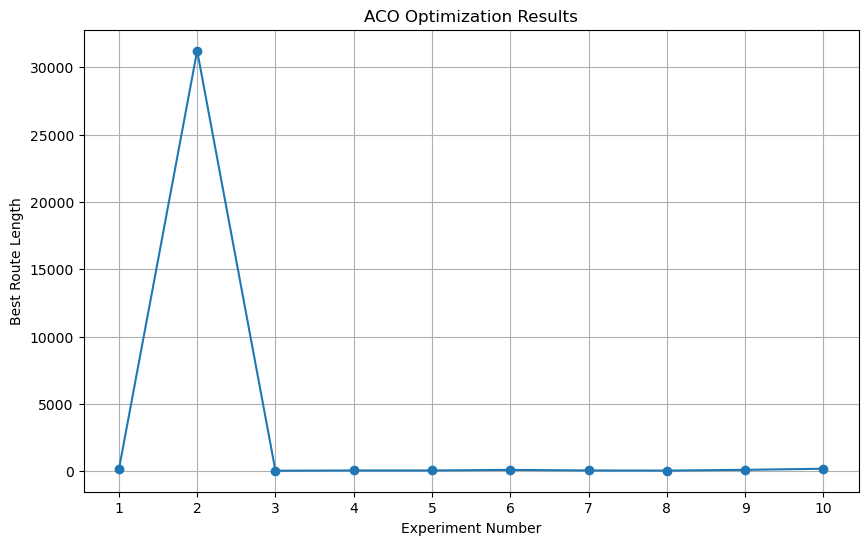

In [8]:
# Define ranges for ACO parameters
param_ranges = {
    'num_ants': (10, 100),
    'num_iterations': (1, 5),
    'decay': (0.01, 0.5),
    'alpha': (0, 5),
    'beta': (0, 5)
}

# Function to generate random ACO parameters within the specified ranges
def randomize_aco_params(param_ranges):
    return {
        'num_ants': random.randint(*param_ranges['num_ants']),
        'num_iterations': random.randint(*param_ranges['num_iterations']),
        'decay': random.uniform(*param_ranges['decay']),
        'alpha': random.uniform(*param_ranges['alpha']),
        'beta': random.uniform(*param_ranges['beta'])
    }

# List to store the results
results = []

# Number of experiments to run
num_experiments = 10

# Run the ACO algorithm with randomized parameters and store the results
for i in range(num_experiments):
    # Randomize ACO parameters
    aco_params = randomize_aco_params(param_ranges)
    print(f"Experiment {i+1} will start with that parameters: {aco_params}")
    
    # Run the parallelized ACO
    best_route, best_length = run_aco_parallel(G, aco_params, num_processes, start_node, end_node)
    
    # Store the results
    results.append({
        'params': aco_params,
        'best_route': best_route,
        'best_length': best_length
    })
    
    # Print the results for this iteration
    print(f"Best length: {best_length}")

# Convert results to a DataFrame and visualize
df_results = pd.DataFrame(results)
df_results['experiment'] = df_results.index + 1

# Plotting the best length for each experiment
plt.figure(figsize=(10, 6))
plt.plot(df_results['experiment'], df_results['best_length'], marker='o')
plt.title('ACO Optimization Results')
plt.xlabel('Experiment Number')
plt.ylabel('Best Route Length')
plt.xticks(range(1, num_experiments+1))
plt.grid(True)
plt.show()

## Post-Processing and Visualization

In [9]:
# Compute summary metrics
best_solution_length = df_results['best_length'].min()
average_length = df_results['best_length'].mean()
std_deviation = df_results['best_length'].std()

# Display the computed metrics
print(f"Best Solution Length: {best_solution_length}")
print(f"Average Solution Length: {average_length}")
print(f"Standard Deviation of Solution Lengths: {std_deviation}")

Best Solution Length: 32.899297899597876
Average Solution Length: 3196.5218673656773
Standard Deviation of Solution Lengths: 9850.170002990923


Parameters for the best solution: {'num_ants': 24, 'num_iterations': 2, 'decay': 0.26064623043745405, 'alpha': 2.532342996221125, 'beta': 0.4491030863149992}
Best route for the best solution: [90, 46, 1, 28, 88]


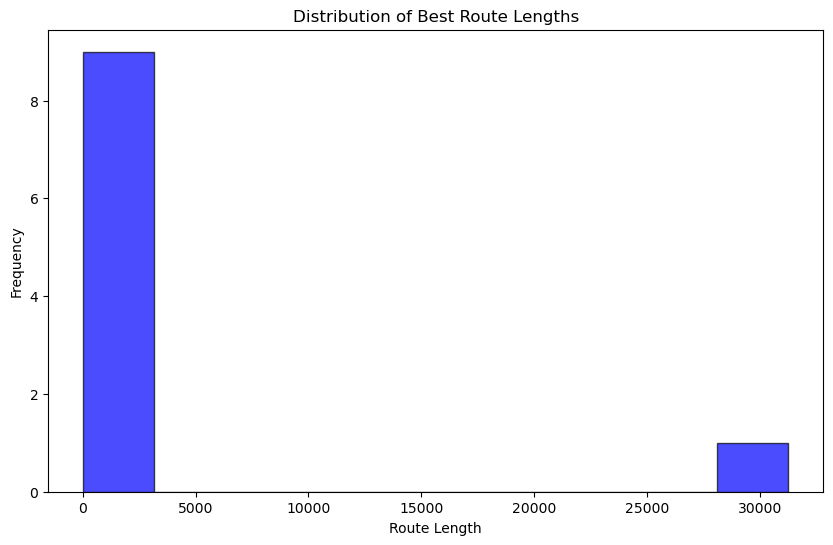

In [24]:
best_row = df_results.loc[df_results['best_length'].idxmin()]
print(f"Parameters for the best solution: {best_row['params']}")
print(f"Best route for the best solution: {best_row['best_route']}")

# Plotting the distribution of best lengths
plt.figure(figsize=(10, 6))
plt.hist(df_results['best_length'], bins=10, alpha=0.7, color='blue', edgecolor='black')
plt.title('Distribution of Best Route Lengths')
plt.xlabel('Route Length')
plt.ylabel('Frequency')
plt.show()

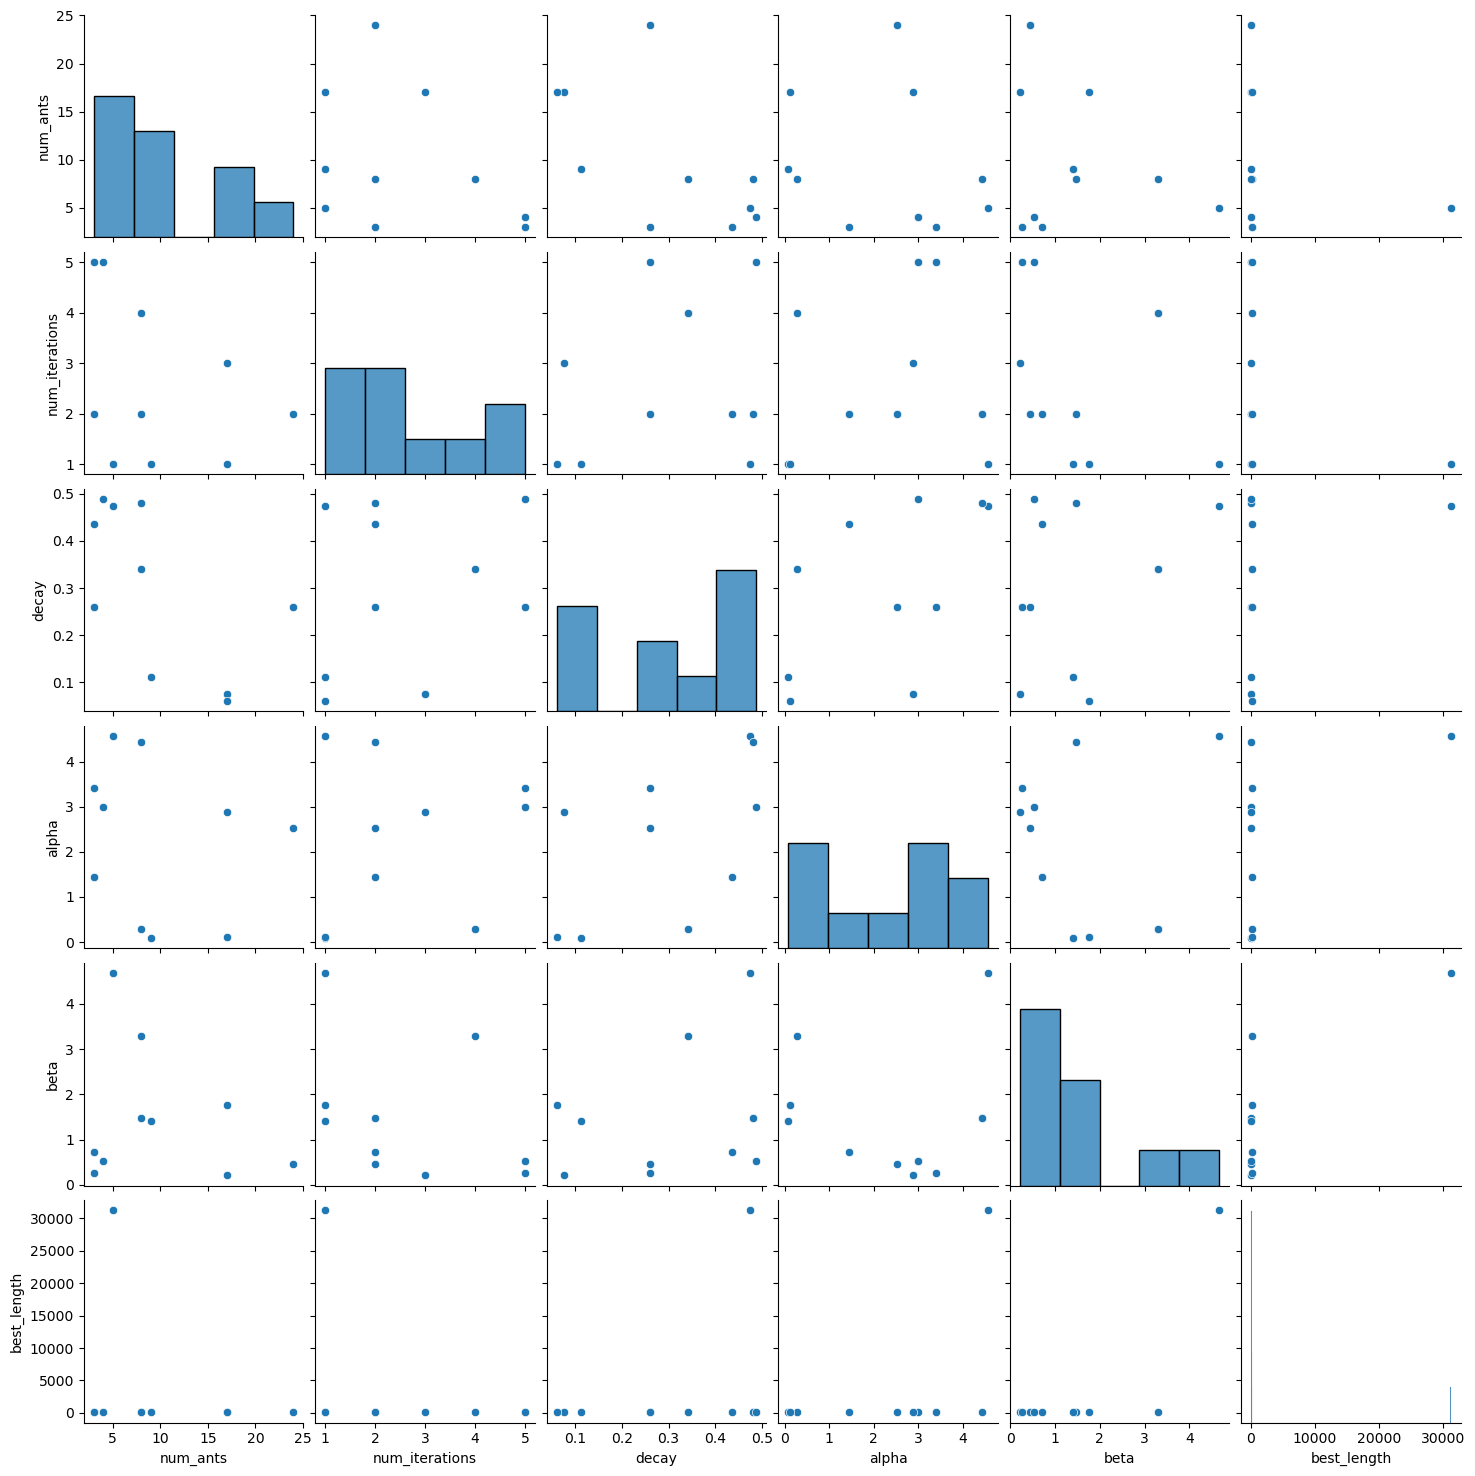

In [11]:
params_df = pd.DataFrame(df_results['params'].tolist())
expanded_df = pd.concat([params_df, df_results['best_length']], axis=1)

# use seaborn to create pair plots or correlation heatmaps to analyze the parameter effects
sns.pairplot(expanded_df)
plt.show()


                num_ants  num_iterations     decay     alpha      beta  \
num_ants        1.000000       -0.352068 -0.608375 -0.211655 -0.225559   
num_iterations -0.352068        1.000000  0.231950  0.176398 -0.363817   
decay          -0.608375        0.231950  1.000000  0.556766  0.295158   
alpha          -0.211655        0.176398  0.556766  1.000000  0.033003   
beta           -0.225559       -0.363817  0.295158  0.033003  1.000000   
best_length    -0.235940       -0.356761  0.357836  0.467999  0.769547   

                best_length  
num_ants          -0.235940  
num_iterations    -0.356761  
decay              0.357836  
alpha              0.467999  
beta               0.769547  
best_length        1.000000  


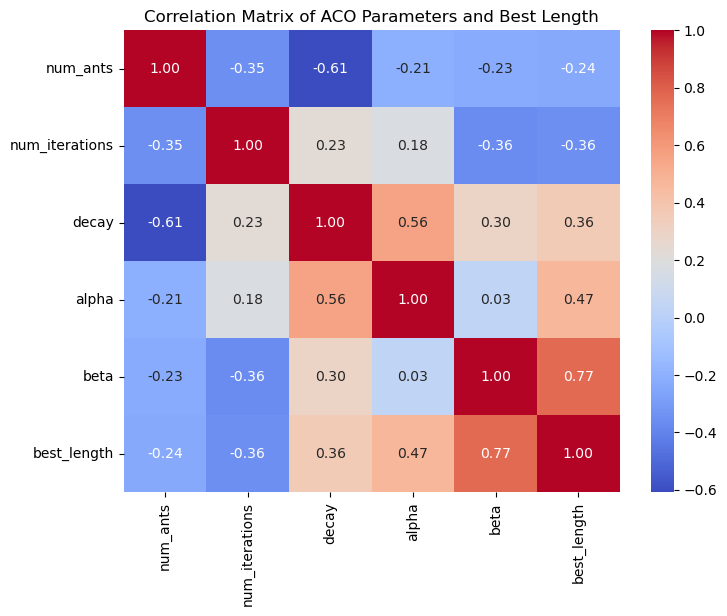

In [19]:
# Convert the 'params' column into separate columns
params_df = df_results['params'].apply(pd.Series)

# Combine the new parameter columns with the 'best_length' column
combined_df = pd.concat([params_df, df_results['best_length']], axis=1)

# Perform correlation analysis
correlation_matrix = combined_df.corr()

# Display the correlation matrix
print(correlation_matrix)

# Plot a heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of ACO Parameters and Best Length')
plt.show()


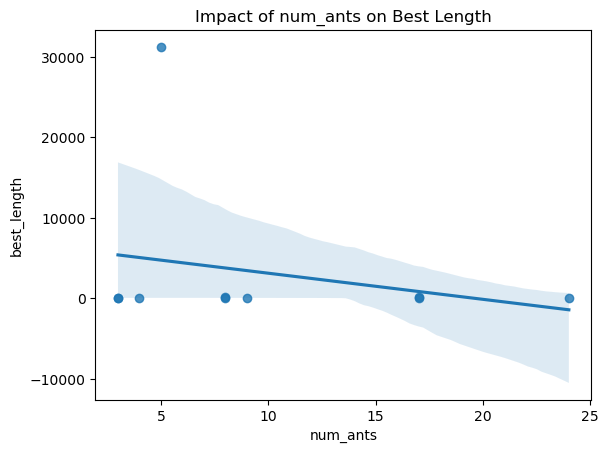

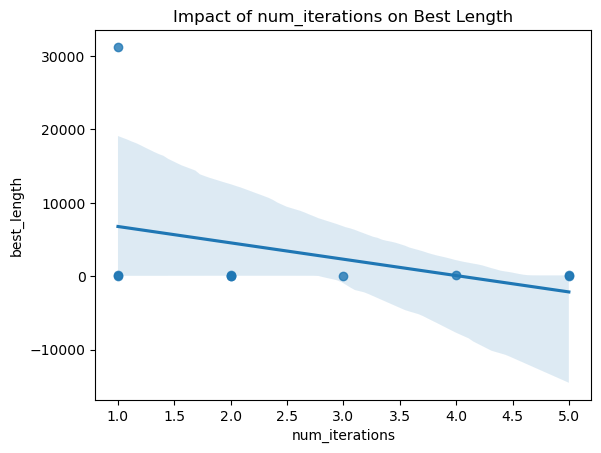

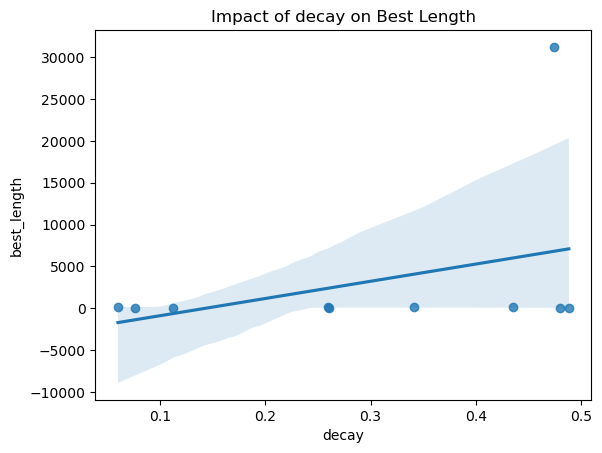

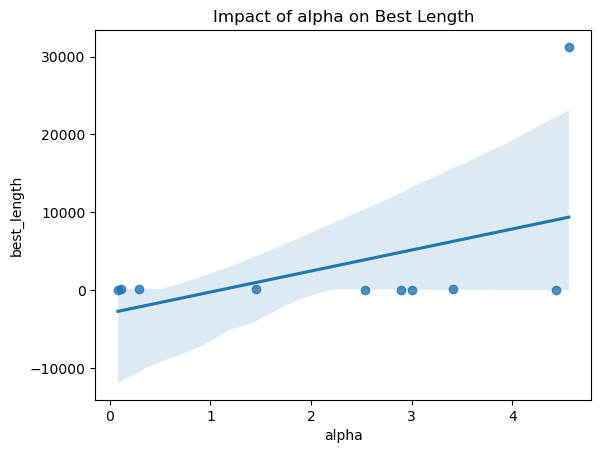

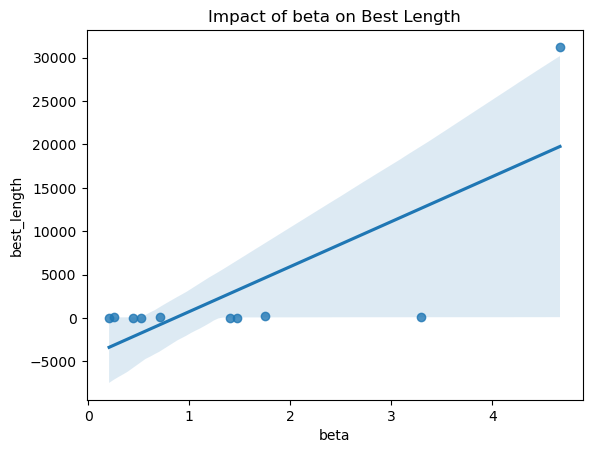

In [20]:
for param in params_df.columns:
    sns.regplot(x=param, y='best_length', data=combined_df)
    plt.title(f'Impact of {param} on Best Length')
    plt.show()

The correlation matrix shows the relationships between different ACO parameters (<b>num_ants</b>, <b>num_iterations</b>, <b>decay</b>, <b>alpha</b>, <b>beta</b>) and the <b>best_length</b>. Here's a breakdown of what the correlations might suggest:
<ol>
    <li><b>num_ants</b>: There's a negative correlation with <b>best_length</b> (-0.235940), indicating that as the number of ants increases, the best length tends to decrease, although the correlation is not very strong.</li>
    <li><b>num_iterations</b>: Also shows a negative correlation with <b>best_length</b> (-0.356761), which might suggest that more iterations could lead to shorter (better) paths. This correlation is moderate.</li>
    <li><b>decay</b>: There's a positive correlation with <b>best_length</b> (0.357836), which could indicate that higher pheromone decay rates may lead to longer paths. This is a moderate positive correlation.</li>
    <li><b>alpha</b>: Shows a moderate positive correlation with <b>best_length</b> (0.467999). This might mean that increased importance of the pheromone trail can potentially lead to longer paths; however, this is counterintuitive as typically, a higher <b>alpha</b> would make the algorithm more exploitative of known good paths.</li>
    <li><b>beta</b>: Has a strong positive correlation with <b>best_length</b> (0.769547). This suggests that the higher importance of heuristic information (distance to the next node) is strongly associated with finding longer paths, which is unexpected as typically a higher <b>beta</b> promotes exploration and could help find shorter paths.</li>
</ol>

Based on these correlations, we would typically expect the following for ACO parameter tuning:
<ul>
    <li>Increasing <b>num_ants</b> and <b>num_iterations</b> might improve the algorithm's performance (shorter <b>best_length</b>), given the negative correlations.</li>
    <li>A lower <b>decay</b> might be associated with better solutions, contrary to what the positive correlation suggests.</li>
    <li>For <b>alpha</b> and <b>beta</b>, the positive correlations with <b>best_length</b> are puzzling because higher values for these parameters are generally expected to improve the search for shorter paths. The observed correlations might suggest an imbalance in the parameter tuning, perhaps overly emphasizing pheromone strength or heuristic information to the detriment of exploration or exploitation balance.</li>
</ul>

It is important to note that correlations do not imply causation and may not provide a complete understanding of the complex dynamics in an ACO algorithm. Additionally, ACO performance is typically problem-specific, and optimal parameters can vary widely between different types of problems and instances.